In [1]:
from TKV_REG import *
from GCV import *
from KERNEL import *
from BLUR import *
from ESF import *
from EVALSIG import *

import matplotlib.pyplot as plt
from matplotlib import rc

from tqdm.notebook import tqdm

#rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
#rc('text', usetex=True)

ESFFUNC = logistic

In [2]:
FILE = "presentation_signals.csv"
sigs = open(FILE, 'r')
smooth = sigs.readline()
sigs.close()
smooth = smooth.split(',')
smooth = [float(i) for i in smooth]
x = np.asarray(smooth).reshape(len(smooth), 1)
A = kernel(x.shape[0], 16)
b = blur(x, A, True, 0.01)

In [3]:
calib_x = []
for i in range(512):
    if i < 256:
        calib_x.append(0.)
    else:
        calib_x.append(1.)
calib_x = np.asarray(calib_x).reshape(len(calib_x), 1)
calib_b = blur(calib_x, A, True, 0.01)

calib_b = calib_b[100:412, 0]
calib_b = normalize_edge(calib_b)

In [4]:
n = 256
k = [np.random.random() for i in range(n)]
mses = [find_mse(calib_b, ESFFUNC(term, len(calib_b))) for term in k]
m = find_index(min(mses), mses)

In [5]:
thresholdResults = []
mmse = 0.0005
for i in range(len(mses)):
    if mses[i] <= mmse:
        thresholdResults.append([mses[i], k[i]])

displayResults = []
minParam = 10000
maxParam = 0
optimalParam = k[m]
for i in thresholdResults:
    if i[1] < minParam:
        minParam = i[1]
    elif i[1] > maxParam:
        maxParam = i[1]

params = [minParam, optimalParam, maxParam]
print(f"MinParam: {minParam}")
print(f"OptimalParam: {optimalParam}")
print(f"MaxParam: {maxParam}")

MinParam: 0.08910377329237174
OptimalParam: 0.10626427998352028
MaxParam: 0.1323671815637072


In [6]:
plots = []
le = len(b)
togglePbar(1)
for i in params:
    fit = ESFFUNC(i, le)
    dFit = diff(fit, le)
    dFit = normalize_diff(dFit[le//2:])
    A = generateBlurMatrix(le, dFit)
    out, gcv = run_gcv(A, b, tkv_regularize, 12)
    #out = tkv_regularize(b, A, 0.02)
    plots.append(out)

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

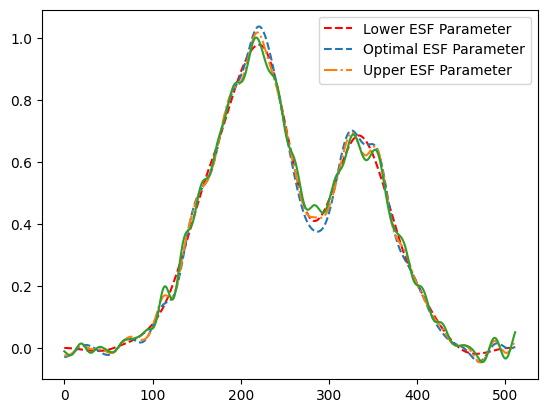

In [7]:
plt.plot(x, 'r--')
plt.plot(plots[0], '--')
plt.plot(plots[1], '-.')
plt.plot(plots[2])

plt.legend(["Lower ESF Parameter", "Optimal ESF Parameter", "Upper ESF Parameter"])
plt.show()

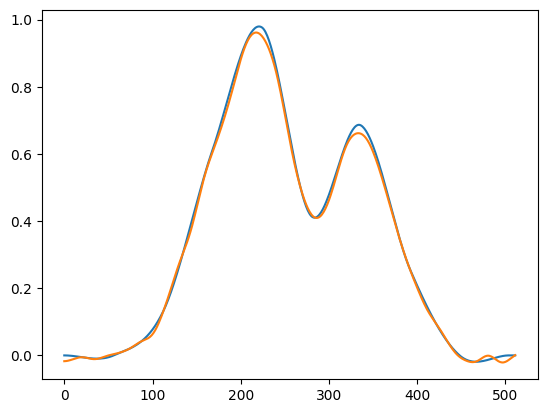

In [8]:
plt.plot(smooth)
plt.plot(plots[1])
plt.show()

0.5
0.5000000000000007


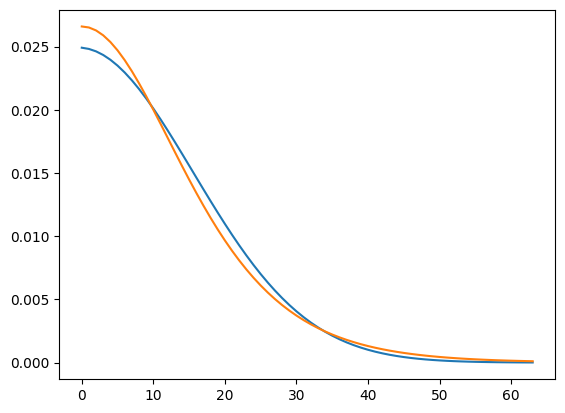

In [9]:
test = np.diff(st.norm.cdf(np.linspace(0, 512/16, 513)))
test = test/sum(test)/2

fit = ESFFUNC(optimalParam, le)
dFit = diff(fit, le)
dFit = normalize_diff(dFit[le//2:])

print(sum(test))
print(sum(dFit))

plt.plot(test[0:64])
plt.plot(dFit[0:64])
plt.show()

In [0]:
# THIS ISN'T EVEN REMOTELY USEFUL BUT IS KEPT IN THE EVENT THAT IT IS NEEDED
#esf_mses = []
#gcvs = []
#le = len(b)
#togglePbar(-1)
#with tqdm(total=len(thresholdResults)) as pbar:
#    for i in thresholdResults:
#        fit = ESFFUNC(i[1], le)
#        dFit = diff(fit, le)
#        dFit = normalize_diff(dFit[le//2:])
#        A = generateBlurMatrix(le, dFit)
#        out, gcv = run_gcv(A, b, tkv_regularize, 3)
#        #out = tkv_regularize(b, A, 0.002296736176338)
#        pl = find_mse(list(x[0]), list(out[0]))
#        gcvs.append(gcv)
#
#        esf_mses.append(pl)
#        pbar.update(1)

In [10]:
fit = ESFFUNC(i, le)
dFit = diff(fit, le)
dFit = normalize_diff(dFit[le//2:])
A = generateBlurMatrix(le, dFit)
out, gcv = run_gcv(A, b, tkv_regularize, 50)

  0%|          | 0/500 [00:00<?, ?it/s]

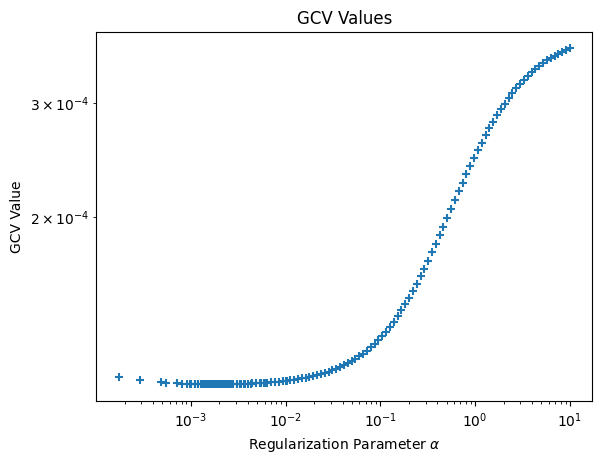

In [11]:
plt.scatter(*zip(*gcv), 40, marker="+")
plt.xscale("log")
plt.yscale("log")

plt.title("GCV Values")
plt.xlabel(r"Regularization Parameter $\alpha$")
plt.ylabel("GCV Value")
plt.show()